# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair

# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
solutions = '../data'

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, root, file)

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def load_sol_from_dir(folder_path: str, column_list, special_column_name: str = "instance_info"):
    """ Load solutions from directory files into table. """
    it = get_file_paths_from_dir(folder_path, include_sol=True, include_instance=False)
    output_table = None
        
    for (dataset, root, file) in it:
        curr_table = pandas.read_csv(f'{root}/{file}', index_col=None, delimiter=" ", header=None).iloc[:,0:3]
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
        curr_table[special_column_name] = file.split("_")[1]
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    return output_table

def load_data_from_dir(folder_path: str, column_list, special_column_name: str = "instance_info"):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, root, file) in it:
        curr_table = pandas.read_csv(f'{root}/{file}', index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
        curr_table[special_column_name] = file.split("_")[1]
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

def construct_table_from(filePair: FilePair):
    solution_table = pandas.read_csv(filePair.solutionFile, header=None, index_col=None, delimiter=" ")
    data_table = pandas.read_csv(filePair.dataFile, header=None, index_col=None, delimiter=" ")
    
    item_count = data_table.iloc[0, 1]
    
    solution_table = solution_table.drop_duplicates(subset=[0], keep='first').reset_index()

    data_table = data_table.iloc[:, 4:]
    data_table = data_table[data_table.columns[::2]]

    info_table = pandas.concat([solution_table.iloc[:, 1], solution_table.iloc[:, 3], data_table.max(axis=1)], axis=1)
    info_table.columns = ["id", "best_value", "max_cost"]
    info_table["item_count"] = item_count
    return info_table

def create_avg_time_table(table, name: str, column_name: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm_name", column_name])['elapsed_time'] \
        .mean().reset_index()
    avg_times = avg_times.round(2)

    # Move all values of algorithm column into separate columns
    #avg_times = avg_times.unstack("algorithm_name")
    #avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column_name}"
    avg_times.sort_values(by=column_name, inplace=True)
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    #avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error_table(table, column_name: str, table_name: str = "unknown"):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per {column_name}"
    
    
    avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")\
        .round(6)\
        .to_excel(f"excel/{table_name}_avg_error.xlsx", sheet_name=table_name)
    
    return avg_error

In [4]:
# Create column lists

sol_cols = ["id", "item_count", "best_value"]
cols = get_cols_list(f'{path}/column_description.dat')

## Put data from all analysis files into tables

In [5]:
# Load tables of all strategies
#balance_table = load_data_from_dir(f'{path}/Balance', cols) \
#    .rename(columns={'instance_info':'balance'})
#robust_table = load_data_from_dir(f'{path}/Robust', cols) \
#    .drop(columns="instance_info")

nk_table = load_data_from_dir(f'{path}/NK', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/NK', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkc_table = load_data_from_dir(f'{path}/ZKC', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKC', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkw_table = load_data_from_dir(f'{path}/ZKW', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKW', sol_cols).drop(columns="dataset"), on=["id", "item_count"])


In [6]:
error_nk = create_avg_error_table(nk_table, "item_count")
error_zkc = create_avg_error_table(zkc_table, "item_count")
error_zkw = create_avg_error_table(zkw_table, "item_count")

time_nk = create_avg_time_table(nk_table, name="initial temperature", column_name="item_count")
time_zkc = create_avg_time_table(zkc_table, name="cooling coefficient", column_name="item_count")
time_zkw = create_avg_time_table(zkw_table, name="number of cycles", column_name="item_count")

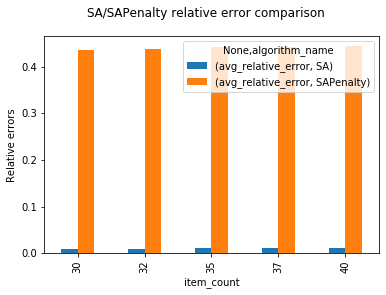

In [7]:
full_table = nk_table.append(zkc_table).append(zkw_table).query("algorithm_name != 'SA_OLD'")
sapenalty_error_comp = create_avg_error_table(full_table, "item_count", "sapenalty_comp")\
    .set_index(["item_count", "algorithm_name"]).unstack("algorithm_name")\
    .drop(columns="max_relative_error")

sapenalty_comp_plot = sapenalty_error_comp.plot.bar(legend=True)
sapenalty_comp_plot.set_ylabel("Relative errors")

figure = sapenalty_comp_plot.get_figure()
figure.suptitle("SA/SAPenalty relative error comparison")
figure.savefig("excel/sapenalty_comp.pdf")

sapenalty_comp_plot

# Parameter analysis
## Analyze the same dataset, change one of the parameters

In [8]:
param_sols = load_sol_from_dir(f'{solutions}/ParamAnalysis', sol_cols) \
    .drop(columns="dataset")

init_temp_table = load_data_from_dir(f'{path}/ParamAnalysis/InitTemperature', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
init_temp_table["init_temp"] = init_temp_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cooling_table = load_data_from_dir(f'{path}/ParamAnalysis/Cooling', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "init_temperature"]) \
    .merge(param_sols, on=["id", "item_count"])
cooling_table["cooling_coef"] = cooling_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].str.replace(",", ".").astype(float)

cycles_table = load_data_from_dir(f'{path}/ParamAnalysis/Cycles', cols) \
    .drop(columns=["things", "init_temperature", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
cycles_table["cycles"] = cycles_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)


In [15]:
error_init_temp = create_avg_error_table(init_temp_table, "init_temp")\
    .query('algorithm_name == "SA"').set_index("init_temp")
error_cooling = create_avg_error_table(cooling_table, "cooling_coef")\
    .query('algorithm_name == "SA"').set_index("cooling_coef")
error_cycles = create_avg_error_table(cycles_table, "cycles")\
    .query('algorithm_name == "SA"').set_index("cycles")

time_init_temp = create_avg_time_table(init_temp_table, name="initial temperature", column_name="init_temp")\
    .query('algorithm_name == "SA"').set_index("init_temp")
time_cooling = create_avg_time_table(cooling_table, name="cooling coefficient", column_name="cooling_coef")\
    .query('algorithm_name == "SA"').set_index("cooling_coef")
time_cycles = create_avg_time_table(cycles_table, name="number of cycles", column_name="cycles")\
    .query('algorithm_name == "SA"').set_index("cycles")


### Initial temperature

          algorithm_name  max_relative_error  avg_relative_error
init_temp                                                       
100                   SA            0.598615            0.017429
300                   SA            0.598615            0.012486
500                   SA            0.598615            0.011925
700                   SA            0.262642            0.009392
900                   SA            0.262642            0.009207
1000                  SA            0.238636            0.008769
1300                  SA            0.233935            0.008577
1600                  SA            0.279835            0.009087
1900                  SA            0.238636            0.009680
2200                  SA            0.233935            0.008654
2500                  SA            0.262642            0.009268
2800                  SA            0.233935            0.008417
3100                  SA            0.233935            0.008572
3500                  SA 

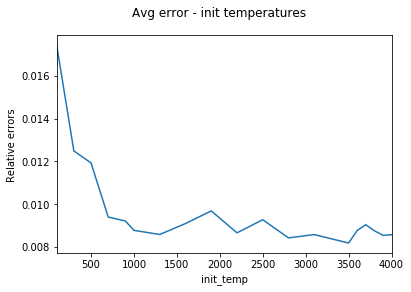

In [28]:
def save_plot(table, title: str, column_name: str, output_name: str, y_label: str = "Relative errors"):
    plot = table.loc[:, column_name].plot()
    plot.set_ylabel(y_label)

    figure = plot.get_figure()
    figure.suptitle(title)
    figure.savefig(f"excel/{output_name}.pdf")
    
    return plot

def save_table(table, output_name):
    table.to_excel(f"excel/{output_name}_table.xlsx", sheet_name=output_name)

print(error_init_temp)

save_table(error_init_temp, "avg_relative_error")
save_plot(error_init_temp, "Avg error - init temperatures", "avg_relative_error", "init_temp_avg_error")


          algorithm_name  elapsed_time
init_temp                             
100                   SA         32.86
300                   SA         40.70
500                   SA         45.85
700                   SA         49.03
900                   SA         50.72
1000                  SA         48.45
1300                  SA         62.94
1600                  SA         51.72
1900                  SA         52.01
2200                  SA         57.18
2500                  SA         55.20
2800                  SA         52.95
3100                  SA         55.94
3500                  SA         62.24
3600                  SA         68.21
3700                  SA         60.79
3800                  SA         68.79
3900                  SA         65.36
4000                  SA         72.73


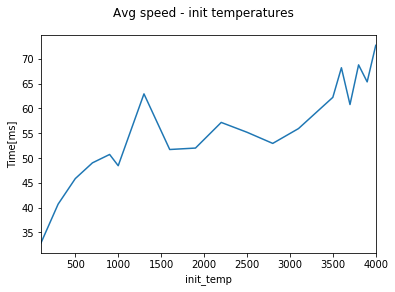

In [29]:
print(time_init_temp)

save_table(time_init_temp, "init_temp_time_ms")
save_plot(time_init_temp, "Avg speed - init temperatures", "elapsed_time", "init_temp_time_ms", "Time[ms]")


### Cooling

In [ ]:
print(error_cooling)
error_cooling.plot()

In [19]:
print(error_cycles.query('algorithm_name == "SA"'))
error_cycles.query('algorithm_name == "SA"').set_index("cycles").loc[:, "avg_relative_error"].plot()

       algorithm_name  max_relative_error  avg_relative_error
cycles                                                       
100                SA            0.598615            0.011660
125                SA            0.598615            0.010841
150                SA            0.598615            0.010922
175                SA            0.598615            0.010941
200                SA            0.598615            0.010768
225                SA            0.598615            0.011280
250                SA            0.598615            0.010561
275                SA            0.327719            0.009548
300                SA            0.262642            0.009170


KeyError: "None of ['cycles'] are in the columns"

# DataAnalysis
## Analyze datasets that were generated differently with fixed SA parameters

In [ ]:
dpath = f'{path}/DataAnalysis'
dsolutions = f'{solutions}/DataAnalysis'

balance_table = load_data_from_dir(f'{dpath}/Balance', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/Balance', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'balance'})
correlation_table = load_data_from_dir(f'{dpath}/Correlation', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/Correlation', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'correlation'})
granularity_heavy_table = load_data_from_dir(f'{dpath}/GranularityHeavy', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/GranularityHeavy', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'constant'})
granularity_light_table = load_data_from_dir(f'{dpath}/GranularityLight', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/GranularityLight', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'constant'})
maxcost_table = load_data_from_dir(f'{dpath}/MaxCost', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/MaxCost', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'maxcost'})
maxweight_table = load_data_from_dir(f'{dpath}/MaxWeight', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/MaxWeight', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'maxweight'})
things_table = load_data_from_dir(f'{dpath}/Things', cols)
weight_cap_ratio_table = load_data_from_dir(f'{dpath}/WeightCapRation', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/WeightCapRation', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'ratio'})


In [ ]:
error_balance = create_avg_error_table(balance_table, "balance")
error_corr = create_avg_error_table(correlation_table, "correlation")
error_granularity_heavy = create_avg_error_table(granularity_heavy_table, "constant")
error_granularity_light = create_avg_error_table(granularity_light_table, "constant")
error_maxcost = create_avg_error_table(maxcost_table, "maxcost")
error_maxweight = create_avg_error_table(maxweight_table, "maxweight")
error_weightcap = create_avg_error_table(weight_cap_ratio_table, "ratio")

In [ ]:
#create_avg_error_table(, "maxcost")
print(error_balance.query('algorithm_name == "SA"'))
error_balance.query('algorithm_name == "SA"').set_index("balance").loc[:, "avg_relative_error"].plot.bar(legend=False)

In [ ]:
print(error_corr.query('algorithm_name == "SA"'))
error_corr.query('algorithm_name == "SA"').set_index("correlation").loc[:, "avg_relative_error"].plot.bar(legend=False)

In [ ]:
print(error_granularity_heavy.query('algorithm_name == "SA"'))
error_granularity_heavy.query('algorithm_name == "SA"').set_index("constant").loc[:, "avg_relative_error"].plot()

In [ ]:
print(error_granularity_light.query('algorithm_name == "SA"'))
error_granularity_light.query('algorithm_name == "SA"').set_index("constant").loc[:, "avg_relative_error"].plot()

In [ ]:
print(error_maxcost.query('algorithm_name == "SA"'))
error_maxcost.query('algorithm_name == "SA"').set_index("maxcost").loc[:, "avg_relative_error"].plot()

In [ ]:
print(error_maxweight.query('algorithm_name == "SA"'))
error_maxweight.query('algorithm_name == "SA"').set_index("maxweight").loc[:, "avg_relative_error"].plot()

In [ ]:
print(error_weightcap.query('algorithm_name == "SA"'))
error_weightcap.query('algorithm_name == "SA"').set_index("ratio").loc[:, "avg_relative_error"].plot()